In [1]:
import torch
from py09_FashionMNIST_Dataset import load_data_fashion_mnist,get_fashion_mnist_labels,image_show
from deeplearn_tools import *

In [2]:
num_inputs = 28*28
num_outputs = 10
w = torch.normal(0,0.01,size=(num_inputs,num_outputs),requires_grad=True)
b = torch.zeros(num_outputs,requires_grad=True)

In [3]:
def liner_reg(X,w=w,b=b):
    return torch.matmul(X,w)+b 

In [4]:
def softmax(X):
    mat_exp = torch.exp(X)
    mat_sum = mat_exp.sum(1,keepdim=True)
    return mat_exp/mat_sum

In [19]:
def loss(preds,trues):
    # with torch.no_grad():
    #     y_label = torch.zeros(X.shape)
    #     for i in range(labels.shape[0]):
    #         y_label[i,labels[i,0]] = 1 
    #     l = -1 * y_label * torch.log(X)
    truth_list = preds[range(trues.shape[0]),trues.reshape(-1)]
    Cross_entropy_loss = -torch.log(truth_list)
    # with torch.no_grad():
    #     print("loss_true:",torch.allclose(l.sum(),a.sum()))
    return Cross_entropy_loss

In [15]:
def net(X):
    liner_out=liner_reg(X,w,b)
    softmax_out=softmax(liner_out)
    return softmax_out

In [7]:
def sgd(params,lr,batch_size):
    with torch.no_grad():
        for para in params:
            para -= lr * para.grad/batch_size
            para.grad.zero_() 

In [8]:
def accuracy(y_hat,y):
    y_hat = y_hat.argmax(dim=1)
    cmp = y_hat.type(y.dtype) == y.reshape(y_hat.shape)
    return float(cmp.sum())

In [9]:
def evaluate_accuracy(net,data_iter):
    """计算在指定数据集的精度"""
    if isinstance(net,torch.nn.Module):
        # 评估模式，不会计算梯度
        net.eval()
    metric = Accumulator(2)
    for X,y in data_iter:
        X = X.reshape(-1,28*28)
        y = y.reshape(-1,1)
        metric.add(accuracy(net(X),y),y.numel())
    return metric[0]/metric[1]

In [21]:
def train(net, train_iter, loss, Optimizer):
    if isinstance(net, torch.nn.Module):
        net.train()
    metric = Accumulator(3)
    for X, y in train_iter:
        X = X.reshape(-1,28*28)
        y = y.reshape(-1,1)
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(Optimizer, torch.optim.Optimizer):
            Optimizer.zero_grad()
            l.backward()
            Optimizer.step()
            metric.add(float(l) * len(y), accuracy(y_hat, y), y.numel())
        else:
            l.sum().backward()
            Optimizer(X.shape[0])
            metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    return metric[0] / metric[2], metric[1] / metric[2]

In [11]:
def train_vis(net, train_iter, test_iter,loss, Optimizer,num_epochs):
    animator =Animator(xlabel="epoch",xlim=[1,num_epochs],ylim=[0.3, 0.9],legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_loss,train_acc = train(net, train_iter, loss, Optimizer)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch+1,(train_loss,train_acc,test_acc))
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [12]:
def Optimizer(batch_size):
    lr = 0.1
    params = [w,b]
    return sgd(params,lr,batch_size)

In [24]:
def predict(net,test_iter,n=6):
    for X,y in test_iter:
        break
    X = X.reshape(-1,28*28)
    y = y.reshape(-1,1)
    trues = get_fashion_mnist_labels(y)
    preds = get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true + '\n' + pred for true,pred in zip(trues,preds)]
    image_show(X[0:n].reshape((-1,28,28)),1,n,titles=titles[0:n])

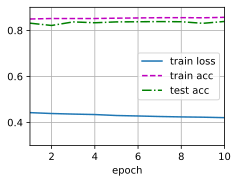

In [26]:
num_epochs = 10
batch_size =  256
train_iter, test_iter = load_data_fashion_mnist(batch_size)
train_vis(net, train_iter, test_iter,loss, Optimizer,num_epochs)

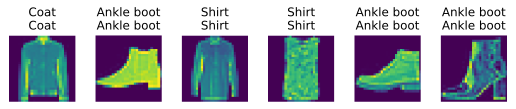

In [27]:
predict(net,test_iter)